# Text classification using machine learning

Run this code __AFTER__ *preprocessing.ipynb*!

## 1. Start-up code: Import packages and get data

In [1]:
# UNCOMMENT TO INSTALL PACKAGES
#!pip install pandas numpy seaborn matplotlib scikit-learn

In [2]:
# system tools
import os
import re

# data wrangling
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
# define path
path = os.path.join("..", "in", "balanced_dataset.csv")

In [4]:
# read csv
df = pd.read_csv(path)
# make sure ratings are parsed as strings and not integers
df['rating'] = df['rating'].astype(str)

In [5]:
# create a new column 'category_id' with encoded categories 
df['category_id'] = df['rating'].factorize()[0]
# remove duplicates
category_id_df = df[['rating', 'category_id']].drop_duplicates()
# create dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'rating']].values)

## Vectorisation

### TD-IDF

In [6]:
# vectorise the texts
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df= 5, # exclude tokens that occurred in less than 5 texts
                        ngram_range=(1, 2), # get uni- and bigrams
                        encoding = 'utf-16',
                        max_features = None)
# transform each review into a vector
features = tfidf.fit_transform(df['review'].values.astype('str')).toarray()

# get labels
labels = df.category_id
print("Each of the %d reviews is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 85265 reviews is represented by 22959 features (TF-IDF score of unigrams and bigrams)


In [7]:
N = 15 # number of correlated terms, we want to find
out_file = os.path.join("..", "out", "machine_learning_output", "correlated_terms.txt")

# find and write most correlated terms into a .txt-file
with open(out_file, 'w') as f: 
    f.write("MOST CORRELATED TERMS PER CATEGORY\n")
    for rating, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names_out())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        f.write("n==> %s:\n" %(rating))
        f.write("  * Most Correlated Unigrams are: %s\n\n" %(', '.join(unigrams[-N:])))
        f.write("  * Most Correlated Bigrams are: %s\n\n\n" %(', '.join(bigrams[-N:])))
print("Correlated terms have been written to '%s'." % out_file)

Correlated terms have been written to '../out/machine_learning_output/correlated_terms.txt'.


## Finding the best classifier

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [9]:
# list of models we want to test
models = [
    LogisticRegression(random_state=42, max_iter = 85265),
    MultinomialNB(),
    ComplementNB(),
    LinearSVC()
]

In [10]:
# cross-validation
CV = 3 # the number of k-folds into which the dataset is divided during cross-validation
cv_df = pd.DataFrame(index=range(CV * len(models)))
model_names = ["LogisticRegression", "MultinomialNB", "ComplementNB", "LinearSVC"] # model names

entries = []
counter = 0
for model in models:
    title = model_names[counter]
    print(f"{title}...")
    counter += 1
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV) # cross-validate models based on accuracy
    for fold_idx, accuracy in enumerate(accuracies): # list of accuracies
        entries.append((model_name, accuracy))
    print(f"Complete!\n")
# create mean accuracy df
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

LogisticRegression...
Complete!

MultinomialNB...
Complete!

ComplementNB...
Complete!

LinearSVC...
Complete!



In [11]:
# show cross-validation results
cv_results = cv_df.groupby(by = "model_name", as_index = False).mean().sort_values(by="accuracy", ascending=False)
# create a path for saving the cross-validation results
cv_path = os.path.join("..", "out", "machine_learning_output", "cross-validations_acuracies.csv")
# save the CSV
cv_results.to_csv(cv_path, index = False)

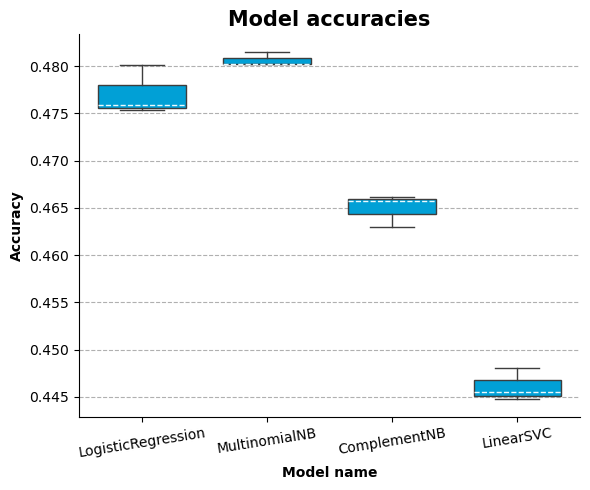

In [12]:
# plot cross-validation results
plt.rc('axes', axisbelow=True) # place gridlines below elements in plots

# boxplot
fig, ax = plt.subplots(figsize=(6,5))

ax = sns.boxplot(x='model_name', y='accuracy', 
                 data=cv_df,
                 linewidth=1,
                 width=0.7,
                 fliersize=5,
                 boxprops={"facecolor": "#01a0d6"}, 
                 medianprops={"linewidth" : 1, "linestyle" : "--", "color" : "#edfbfe"})
plt.title("Model accuracies", weight = "bold", fontsize=15)
plt.ylabel("Accuracy", fontsize=10, weight="bold")
plt.xlabel("Model name", fontsize=10, weight="bold")
plt.grid(axis="y", linestyle='--')
plt.xticks(rotation=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()  # adjust layout to prevent labels from being cut off

# save figure
fig_path = os.path.join("..", "out", "machine_learning_output", "model_accuracies.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

# show figure
plt.show()

## Training and testing the classifier

In [13]:
# train-test split
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=42)
# initialize model
model = MultinomialNB()
# fit on training data
model.fit(X_train, y_train)
# predict test data
y_pred = model.predict(X_test)

In [14]:
# classification report
report = metrics.classification_report(y_test, y_pred, target_names= df['rating'].unique())

# write the classification report to a TXT file
report_path = os.path.join("..", "out", "machine_learning_output", "classification_report.txt")
with open(report_path, 'w') as file:
    file.write(report)

# print the classification report
print('CLASSIFICATION METRICS\n')
print(report)

CLASSIFICATION METRICS

              precision    recall  f1-score   support

           1       0.52      0.60      0.56      4230
           2       0.38      0.40      0.39      4265
           3       0.43      0.36      0.39      4293
           4       0.49      0.35      0.41      4335
           5       0.57      0.71      0.63      4194

    accuracy                           0.48     21317
   macro avg       0.48      0.48      0.48     21317
weighted avg       0.48      0.48      0.47     21317



In [15]:
# define 7 colors for colormap
c = ["#edfbfe", "#aee0f5","#6bcae8","#01a0d6","#1b91b8","#166c8c","#0d4960"]
# define their values
v = [0,.15,.4,.5,0.6,.9,1.]
# zip color codes with values
l = list(zip(v,c))
# create colormap for plotting
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

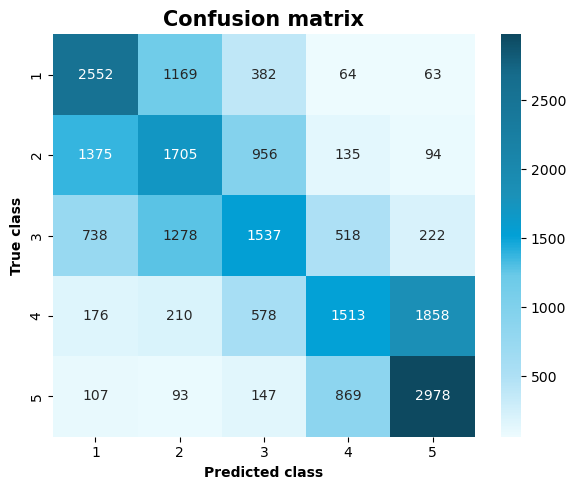

In [16]:
# compute confusion matrix from predictions
conf_mat = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, cmap = cmap, fmt='d',
            xticklabels=category_id_df.rating.values, 
            yticklabels=category_id_df.rating.values)
plt.ylabel('True class', fontsize = 10, weight = "bold")
plt.xlabel('Predicted class', fontsize = 10, weight = "bold")
plt.title("Confusion matrix", weight = "bold", fontsize=15)
plt.tight_layout()  # adjust layout to prevent labels from being cut off

# save the figure
fig_path = os.path.join("..", "out", "machine_learning_output", "confusion_matrix.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

## Prediction of new reviews from TrustPilot

In [17]:
# get X and y
X = df['review']
y = df['rating']

# split the vetorised data again
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [18]:
# initialize a TF-IDF vetorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df= 5,
                        ngram_range=(1, 2), encoding = 'utf-16')
# fit the vetorizer to the training data
fitted_vectorizer = tfidf.fit(X_train.astype('str'))
# vectorize training data
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train.astype('str'))
# fit the model on the vectorized data
model = MultinomialNB().fit(tfidf_vectorizer_vectors, y_train)

In [19]:
# get sample of reviews
path = os.path.join("..", "in", "sample_for_prediction.csv")
pred_df = pd.read_csv(path)

In [20]:
# make predictions for each sample
predicted_classes = []
for rev in pred_df["review"]:
    pred = model.predict(fitted_vectorizer.transform([rev]))
    predicted_classes.append(pred)
# add predictions to the dataframe
pred_df["predicted_class"] = predicted_classes

In [21]:
# create a path for saving the predictions dataframe
pred_path = os.path.join("..", "out", "machine_learning_output", "predictions.csv")
# save the CSV
pred_df.to_csv(pred_path, index = False)